In [22]:
import paco.processing.paco as p
import paco.processing.fullpaco as f_paco
import paco.processing.fastpaco as fastPACO

from paco.util.util import *
import cv2 as cv2
from astropy.convolution import convolve, Gaussian2DKernel, AiryDisk2DKernel
from astropy.modeling.models import Gaussian2D
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm 

from multiprocessing import Pool

# MC Parameters
nFrames = 5
angle = 60
angles = np.linspace(0,angle,nFrames)
psig = [(30,30)]
nTrials = 5
nProcess = min(nTrials,8)
np.random.seed(4096)

This notebook will generate a series of image stacks with gaussian distributed noise backgrounds. Multiple MC trials are run to determine the distribution of the PACO outputs.

In [29]:
def GenerateImageStack(nFrames,angles,signalStrength,noiseLevel,dim = 100):  
    # Hardcoded source location
    p0 = (30,30)
    mean = 0

    images = [np.reshape(np.random.normal(mean, noiseLevel, dim**2), (dim,dim)) for j in range(nFrames)]
    X,Y = np.meshgrid(np.arange(-dim/2, dim/2),np.arange(-dim/2, dim))
    xx, yy = np.meshgrid(np.arange(-30, dim-30),np.arange(-30, dim-30))
    s = gaussian2d(xx,yy,signalStrength/np.sqrt(nFrames), 2)

    #images_signal = [i + s for i in images]
    rot_noise = np.array([rotateImage(images[j], angles[j]) for j in range(nFrames)])
    rot_sigs = np.array([rotateImage(s, angles[j]) for j in range(nFrames)])
    rot_images = np.array([rot_noise[j] + rot_sigs[j] for j in range(nFrames)])
    return rot_images

def GetImPatch(im,px,width):
        k = int(width/2)
        nx, ny = np.shape(im.shape)[:2]
        if px[0]+k > nx or px[0]-k < 0 or px[1]+k > ny or px[1]-k < 0:
            #print("pixel out of range")
            return None
        patch = im[i][int(px[0])-k:int(px[0])+k, int(px[1])-k:int(px[1])+k]
        return patch

def pacoTrial(im_stack):
    #im_stack = GenerateImageStack(nFrames,angles,5.0,1.0)
    fp = fastPACO.FastPACO(image_stack = im_stack,
                           angles = angles)

    a,b = fp.PACO(cpu = 1,
                  model_params={"sigma":2.0},
                  model_name = gaussian2dModel)
    est = fp.fluxEstimate(phi0s = psig,
                          eps = 0.05,
                          initial_est = 0.0)
    return (a,b,est)

In [31]:
trials = [GenerateImageStack(nFrames,angles,5.0,1.0) for i in range(nTrials)]

#for t in trials:
#    print(t[0])
pool = Pool(processes = nProcess)
data = pool.map(pacoTrial,trials)
pool.close()
pool.join()


Precomputing Statistics...
Precomputing Statistics...
Precomputing Statistics...
Precomputing Statistics...
Precomputing Statistics...
Running PACO...
Running PACO...
Running PACO...
Running PACO...
Running PACO...
Done
Computing unbiased flux estimate...
Done
Computing unbiased flux estimate...
Done
Computing unbiased flux estimate...
Done
Computing unbiased flux estimate...
Done
Computing unbiased flux estimate...


In [32]:
print(data[0])
alist,blist,flux = [],[],[]
for d in data:
    alist.append(d[0])
    blist.append(d[1])
    flux.append(d[2])
alist = np.array(alist)
blist = np.array(blist)
flux = np.array(flux)

(array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]]), array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]]), [26.852589212198193])


In [33]:
var = []
peak = []
snr = []
sig = []
var_full = []
#Should do this with numpy slicing...
for i in range(nTrials):
    print(blist[i][30][30],alist[i][30][30])
    var.append(alist[i][30][30])
    peak.append(blist[i][30][30]/ alist[i][30][30])
    snr.append(blist[i][30][30]/ np.sqrt(alist[i][30][30]))
    sig.append(blist[i][30][30])
    var_full.append(np.var(blist[i]/alist[i]))
var = np.array(var)
peak = np.array(peak)
snr = np.array(snr)
var_full = np.array(var_full)


#var = np.array(alist[0:nTrials-1][30][30])
#peak = blist[0:nTrials-1][30][30]/ alist[0:nTrials-1][30][30]
#snr = blist[0:nTrials-1][30][30]/ np.sqrt(alist[0:nTrials-1][30][30])
#sig = blist[0:nTrials-1][30][30]
#var_full = np.var(blist[0:nTrials-1]/ alist[0:nTrials-1])

1.2984015351479612 0.39457341228086035
1.0483836812336118 0.3187382137141679
1.4323928760352724 0.3800737651314047
1.9166650278981032 0.3012940951072934
1.4973748244237681 0.35606440023509295


In [34]:
print(peak)
print(np.var(peak),np.mean(var))

[3.29064629 3.28916847 3.76872336 6.36144239 4.20534831]
1.3025931514518747 0.35014877729376387


/home/evert/.local/share/virtualenvs/PACO-4ds6DMDq/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/home/evert/.local/share/virtualenvs/PACO-4ds6DMDq/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


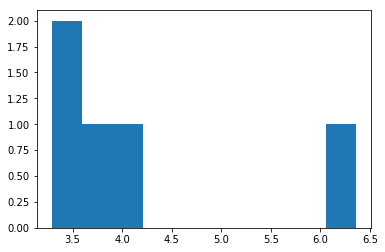

In [35]:
plt.figure()
plt.hist(peak)
plt.show()